## ATAC + MULTIOME (gonadal somatic september 2021)

### Label transfer with Seurat 

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_july2021/figures_somatic/'

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
import anndata2ri
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

**Load data**

In [8]:
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_july2021/"
experiment_prefix = 'supporting_'

In [9]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
table(ATAC_geneScores@meta.data$individual)

 [1] 7752 4967 1114  375 1140 2632 2449 4058 2217 2855  555 3819 4451 4342 8825
[16] 3677 3531 3240 1631 2664 2227 8440


In [10]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE, verbose = TRUE)

RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
table(RNAseq@meta.data$donor)

 [1] 2450 1602  632 1572  397 1443  570  805   21  282 1926  352 2075   79  276
[16] 1909  207  439  136  250  381   47   39 1055  299  579 1271 1123 1611  110
[31] 1157  784 1836 3420  498  523 1489   25 1213  428  801 1579  169  960  108
[46]  862 1827  629 4547 3173 4454


In [11]:
%%R -i RNAseq

print(table(RNAseq@meta.data$somatic_celltype)) 


   CoelEpi_GATA2     CoelEpi_LHX9      FetalLeydig               Gi 
            4000             4000             2874             4000 
             OSE               Oi          Sertoli               Ti 
            4000             4000             4000             4000 
     early_sPAX8    early_somatic early_supporting        granulosa 
            3648             1414             4000              366 
      late_sPAX8          preGC_I        preGC_IIa        preGC_IIb 
            2118             4000             4000             4000 


**Try label transfer with major cluster annotations**

In [12]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:25, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$somatic_celltype, dims = 1:25, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [13]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [14]:
predicted_probabilities

preGC-IIa       OSE   Gi  preGC-I        Oi  \
01-AAACAGCCACTAGCGT-1   0.000000  0.000000  0.0      0.0  0.000000   
01-AAACCGGCAACCCTCC-1   0.032283  0.000000  0.0      0.0  0.000000   
01-AAACCGGCAAGTAAGC-1   0.103812  0.000000  0.0      0.0  0.000000   
01-AAACGGATCCGCCAAA-1   0.059112  0.892645  0.0      0.0  0.000000   
01-AAACGTACAGGTTATT-1   0.038456  0.000000  0.0      0.0  0.000000   
...                          ...       ...  ...      ...       ...   
29-TTTGGTTAGTTGCTTG-1   0.068214  0.774457  0.0      0.0  0.000000   
29-TTTGGTTCAAGATGCG-1   0.000000  0.000000  0.0      0.0  1.000000   
29-TTTGGTTGTGTAGGAC-1   0.000000  0.000000  0.0      0.0  0.994567   
29-TTTGTGTGTGCTGAAG-1   0.000000  0.014645  0.0      0.0  0.000000   
29-TTTGTGTGTTAACCGT-1   0.000000  0.002276  0.0      0.0  0.000000   

                       early-sPAX8  CoelEpi-LHX9  FetalLeydig        Ti  \
01-AAACAGCCACTAGCGT-1          0.0           0.0          0.0  0.000000   
01-AAACCGGCAACCCTCC-1          0.0           0.0          0.0  0.000000   
01-AAACCGGCAAGTAAGC-1          0.0           0.0          0.0  0.000000   
01-AAACGGATCCGCCAAA-1          0.0           0.0          0.0  0.000000   
01-AAACGTACAGGTTATT-1          0.0           0.0          0.0  0.000000   
...                            ...           ...          ...       ...   
29-TTTGGTTAGTTGCTTG-1          0.0           0.0          0.0  0.000000   
29-TTTGGTTCAAGATGCG-1          0.0           0.0          0.0  0.000000   
29-TTTGGTTGTGTAGGAC-1          0.0           0.0          0.0  0.005433   
29-TTTGTGTGTGCTGAAG-1          0.0           0.0          0.0  0.000000   
29-TTTGTGTGTTAACCGT-1          0.0           0.0          0.0  0.000000   

                       early-supporting  preGC-IIb   Sertoli  early-somatic  \
01-AAACAGCCACTAGCGT-1               0.0   0.397496  0.361519            0.0   
01-AAACCGGCAACCCTCC-1               0.0   0.869140  0.014137            0.0   
01-AAACCGGCAAGTAAGC-1               0.0   0.888004  0.008184            0.0   
01-AAACGGATCCGCCAAA-1               0.0   0.048243  0.000000            0.0   
01-AAACGTACAGGTTATT-1               0.0   0.874909  0.054023            0.0   
...                                 ...        ...       ...            ...   
29-TTTGGTTAGTTGCTTG-1               0.0   0.139682  0.017648            0.0   
29-TTTGGTTCAAGATGCG-1               0.0   0.000000  0.000000            0.0   
29-TTTGGTTGTGTAGGAC-1               0.0   0.000000  0.000000            0.0   
29-TTTGTGTGTGCTGAAG-1               0.0   0.985355  0.000000            0.0   
29-TTTGTGTGTTAACCGT-1               0.0   0.856293  0.000000            0.0   

                       CoelEpi-GATA2  late-sPAX8  granulosa       max  
01-AAACAGCCACTAGCGT-1            0.0         0.0   0.240985  0.397496  
01-AAACCGGCAACCCTCC-1            0.0         0.0   0.084440  0.869140  
01-AAACCGGCAAGTAAGC-1            0.0         0.0   0.000000  0.888004  
01-AAACGGATCCGCCAAA-1            0.0         0.0   0.000000  0.892645  
01-AAACGTACAGGTTATT-1            0.0         0.0   0.032612  0.874909  
...                              ...         ...        ...       ...  
29-TTTGGTTAGTTGCTTG-1            0.0         0.0   0.000000  0.774457  
29-TTTGGTTCAAGATGCG-1            0.0         0.0   0.000000  1.000000  
29-TTTGGTTGTGTAGGAC-1            0.0         0.0   0.000000  0.994567  
29-TTTGTGTGTGCTGAAG-1            0.0         0.0   0.000000  0.985355  
29-TTTGTGTGTTAACCGT-1            0.0         0.0   0.141432  0.856293  

[76961 rows x 17 columns]

In [15]:
predicted_probabilities.columns

Index(['preGC-IIa', 'OSE', 'Gi', 'preGC-I', 'Oi', 'early-sPAX8',
       'CoelEpi-LHX9', 'FetalLeydig', 'Ti', 'early-supporting', 'preGC-IIb',
       'Sertoli', 'early-somatic', 'CoelEpi-GATA2', 'late-sPAX8', 'granulosa',
       'max'],
      dtype='object')

Replace dashes with underscores as stupid R changes them

In [16]:
predicted_probabilities.columns = ['preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [17]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")
gene_data

AnnData object with n_obs × n_vars = 76961 × 16693
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'
    uns: 'neighbors', 'umap'
    obsm: 'X_cistopic_45', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

preGC_IIa
OSE
Gi
preGC_I
Oi
early_sPAX8
CoelEpi_LHX9
FetalLeydig
Ti
early_supporting
preGC_IIb
Sertoli
early_somatic
CoelEpi_GATA2
late_sPAX8
granulosa
max


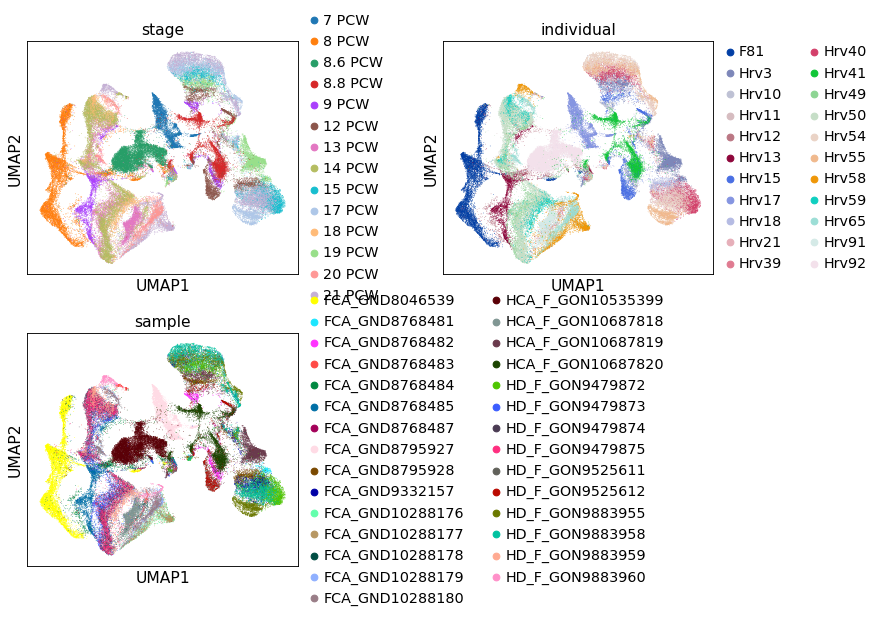

In [19]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.4, 
           save = "_noharmony.pdf")

In [20]:
gene_data.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample',
       'sex', 'stage', 'individual', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi',
       'early_sPAX8', 'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting',
       'preGC_IIb', 'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8',
       'granulosa', 'max'],
      dtype='object')

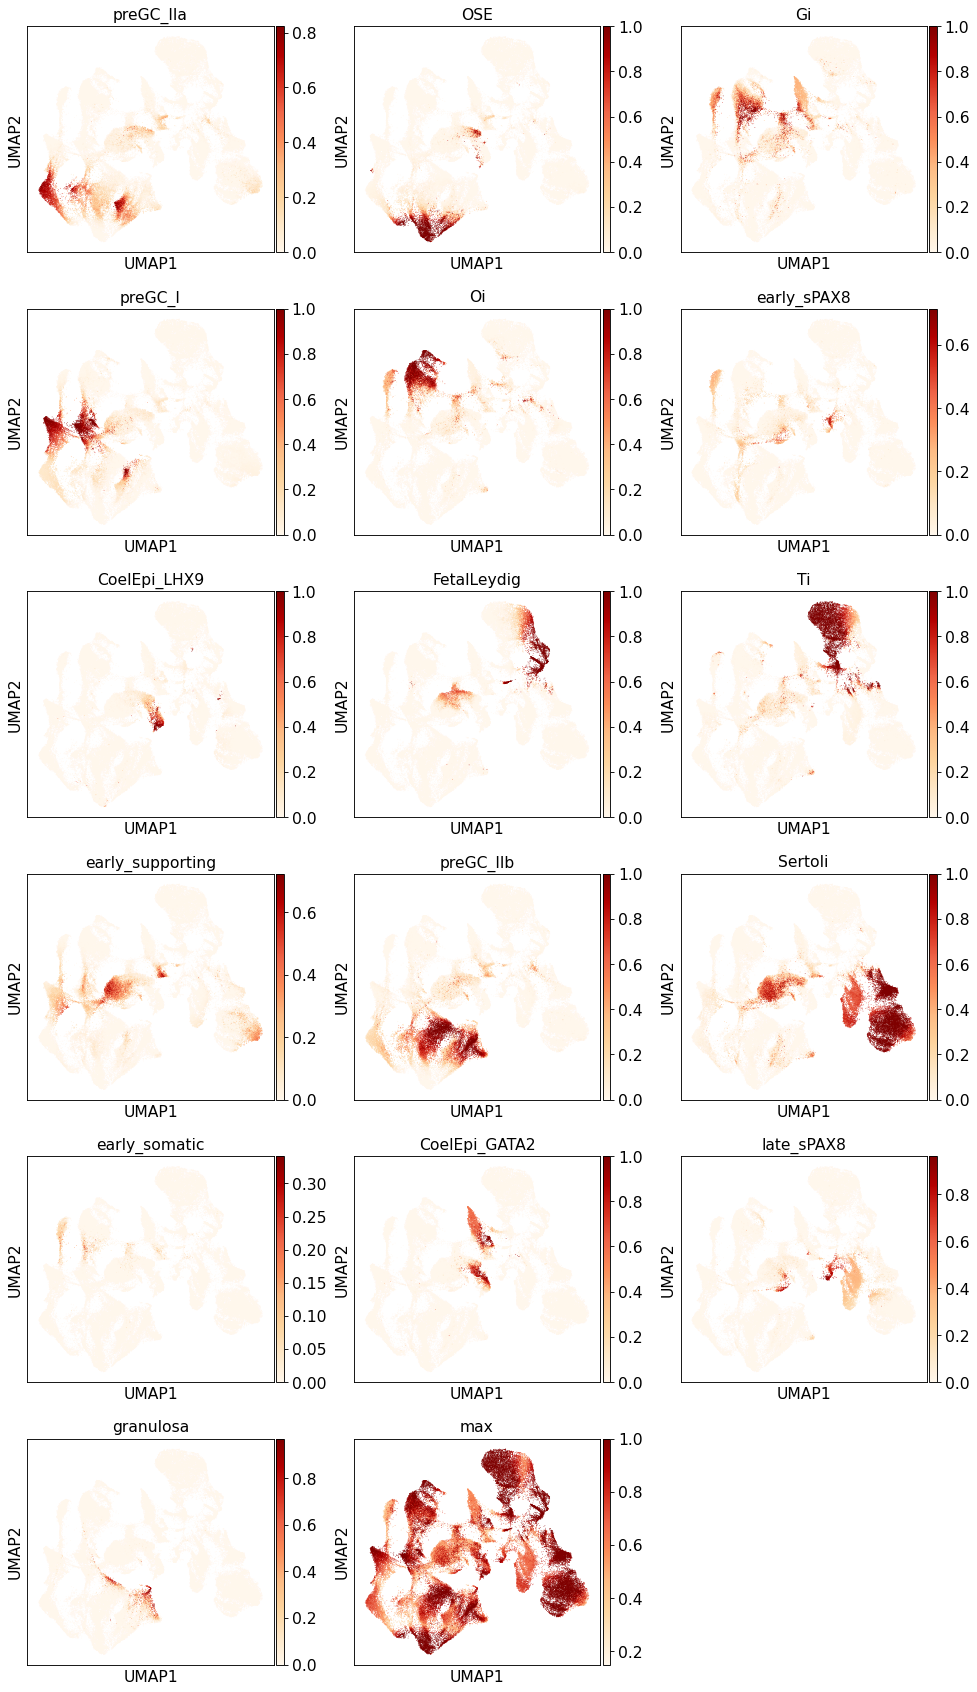

In [21]:
sc.pl.umap(gene_data, color = ['preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       'max'], ncols = 3, color_map = 'OrRd', save = "_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [22]:
gene_data.X

array([[40., 26., 26., ..., 29., 13., 38.],
       [31., 17., 17., ..., 20., 15., 22.],
       [36., 26., 26., ..., 21., 10., 28.],
       ...,
       [28., 16., 16., ...,  8.,  4.,  9.],
       [44., 30., 30., ...,  8.,  5., 10.],
       [42., 30., 30., ..., 10.,  5., 15.]], dtype=float32)

In [23]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([57.932365, 57.823578, 57.024742, ..., 57.756485, 57.521236,
       57.1648  ], dtype=float32)

In [24]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
01-AAACAGCCACTAGCGT-1           57.932365
01-AAACCGGCAACCCTCC-1           57.823578
01-AAACCGGCAAGTAAGC-1           57.024742
01-AAACGGATCCGCCAAA-1           56.442760
01-AAACGTACAGGTTATT-1           57.784283

In [25]:
gene_data.obs['mean_gene_activity'] = means

In [26]:
# sc.pl.umap(gene_data, color = ['mean_gene_activity', 'CKS1B', 'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [27]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'FEN1', 'UNG', 'GINS2', 'MCM6', 'DTL', 'UHRF1', 'NASP', 'WDR76', 'SLBP', 'POLD3', 'MSH2', 'ATAD2', 'RRM2', 'CDC45', 'CDC6', 'BLM', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
['TPX2', 'TOP2A', 'NUF2', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'BUB1', 'KIF11', 'TUBB4B', 'HJURP', 'RANGAP1', 'DLGAP5', 'CDCA2', 'CDCA8', 'KIF23', 'AURKA', 'PSRC1', 'ANLN', 'CKAP5', 'CTCF', 'NEK2', 'CBX5', 'CENPA']


In [28]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [29]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [30]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [31]:
gene_data

AnnData object with n_obs × n_vars = 76961 × 16693
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8', 'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb', 'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'neighbors', 'umap', 'stage_colors', 'individual_colors', 'sample_colors'
    obsm: 'X_cistopic_45', 'X_umap'
    obsp: 'connectivities', 'distances'

**Save the predicted annotations to the peaks anndata object for ATAC**

In [32]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 76961 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_Somatic_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_45', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

In [33]:
for pred in gene_data.obs.columns: 
    if pred in ['preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       'max']:
        print(pred)
        adata.obs[pred] = gene_data.obs[pred]

preGC_IIa
OSE
Gi
preGC_I
Oi
early_sPAX8
CoelEpi_LHX9
FetalLeydig
Ti
early_supporting
preGC_IIb
Sertoli
early_somatic
CoelEpi_GATA2
late_sPAX8
granulosa
max


In [34]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

In [35]:
adata.obs['multiome_Somatic'].value_counts()

nan                 54996
Sertoli              5582
preGC_I              2830
preGC_IIa            2637
Mesenchymal_LHX9     2484
preGC_IIb            1621
early_sPAX8          1549
OSE                  1147
FetalLeydig          1100
early_supporting      999
granulosa             937
OSE_cycling           572
CoelEpi_LHX9          507
Name: multiome_Somatic, dtype: int64

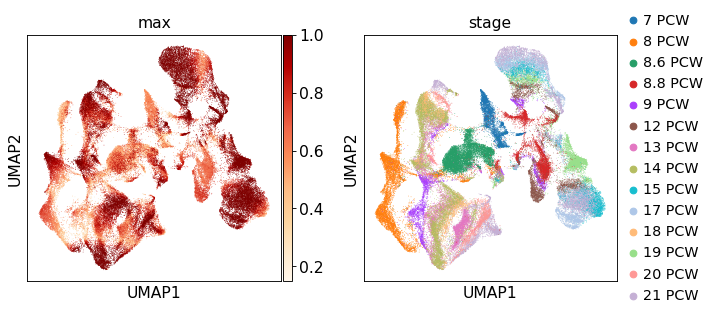

In [36]:
sc.pl.umap(adata, color = ['max', 'stage'], color_map = 'OrRd')

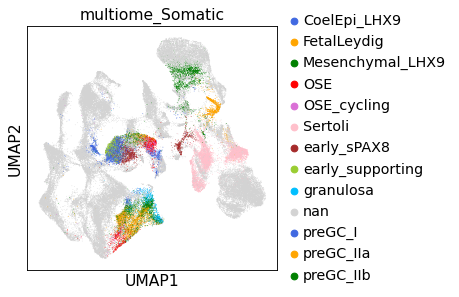

In [37]:
sc.pl.umap(adata, color = 'multiome_Somatic')

### Harmony integration

In [38]:
adata

AnnData object with n_obs × n_vars = 76961 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8', 'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb', 'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_Somatic_colors', 'neighbors', 'sample_colors', 

In [39]:
# Extract PCA matrix and batch array
n_pcs = 45
pca = adata.obsm['X_cistopic_45'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [40]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, lambda = 4, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [41]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [42]:
sc.pp.neighbors(adata, use_rep= 'X_harmony', n_neighbors = 15, random_state=1234)

In [46]:
sc.tl.umap(adata,  min_dist = 0.5, spread = 1)

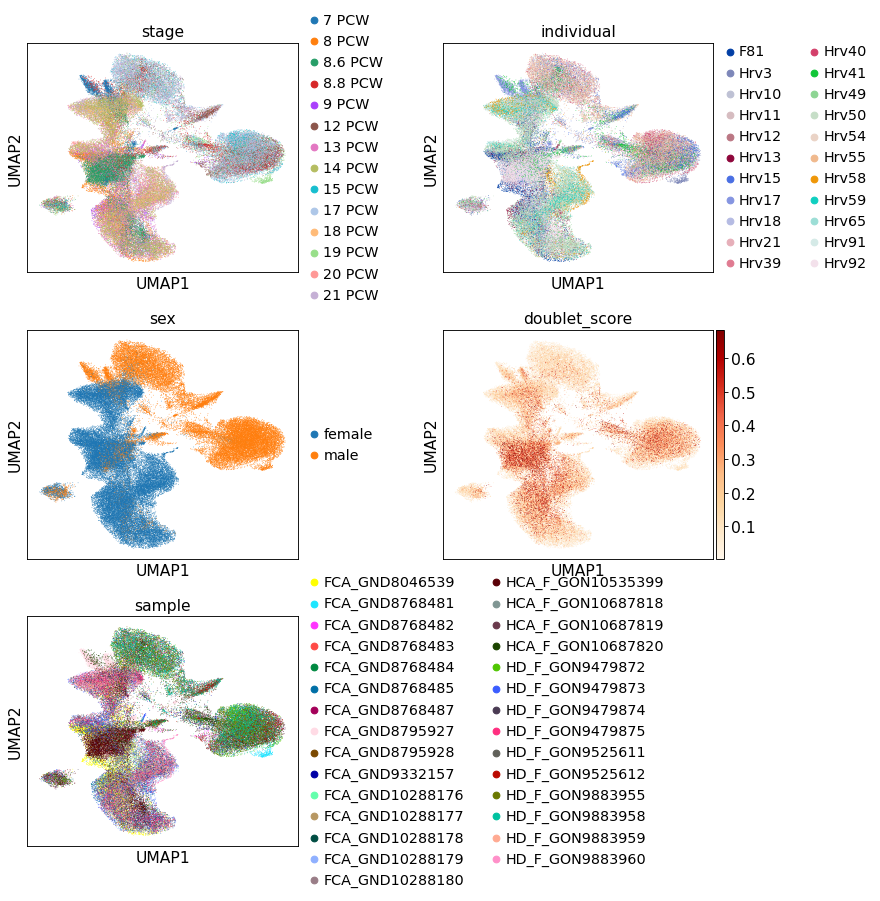

In [47]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sex', 'doublet_score', 'sample'], ncols = 2, wspace = 0.4, 
     save = "metadata.pdf", color_map = 'OrRd')

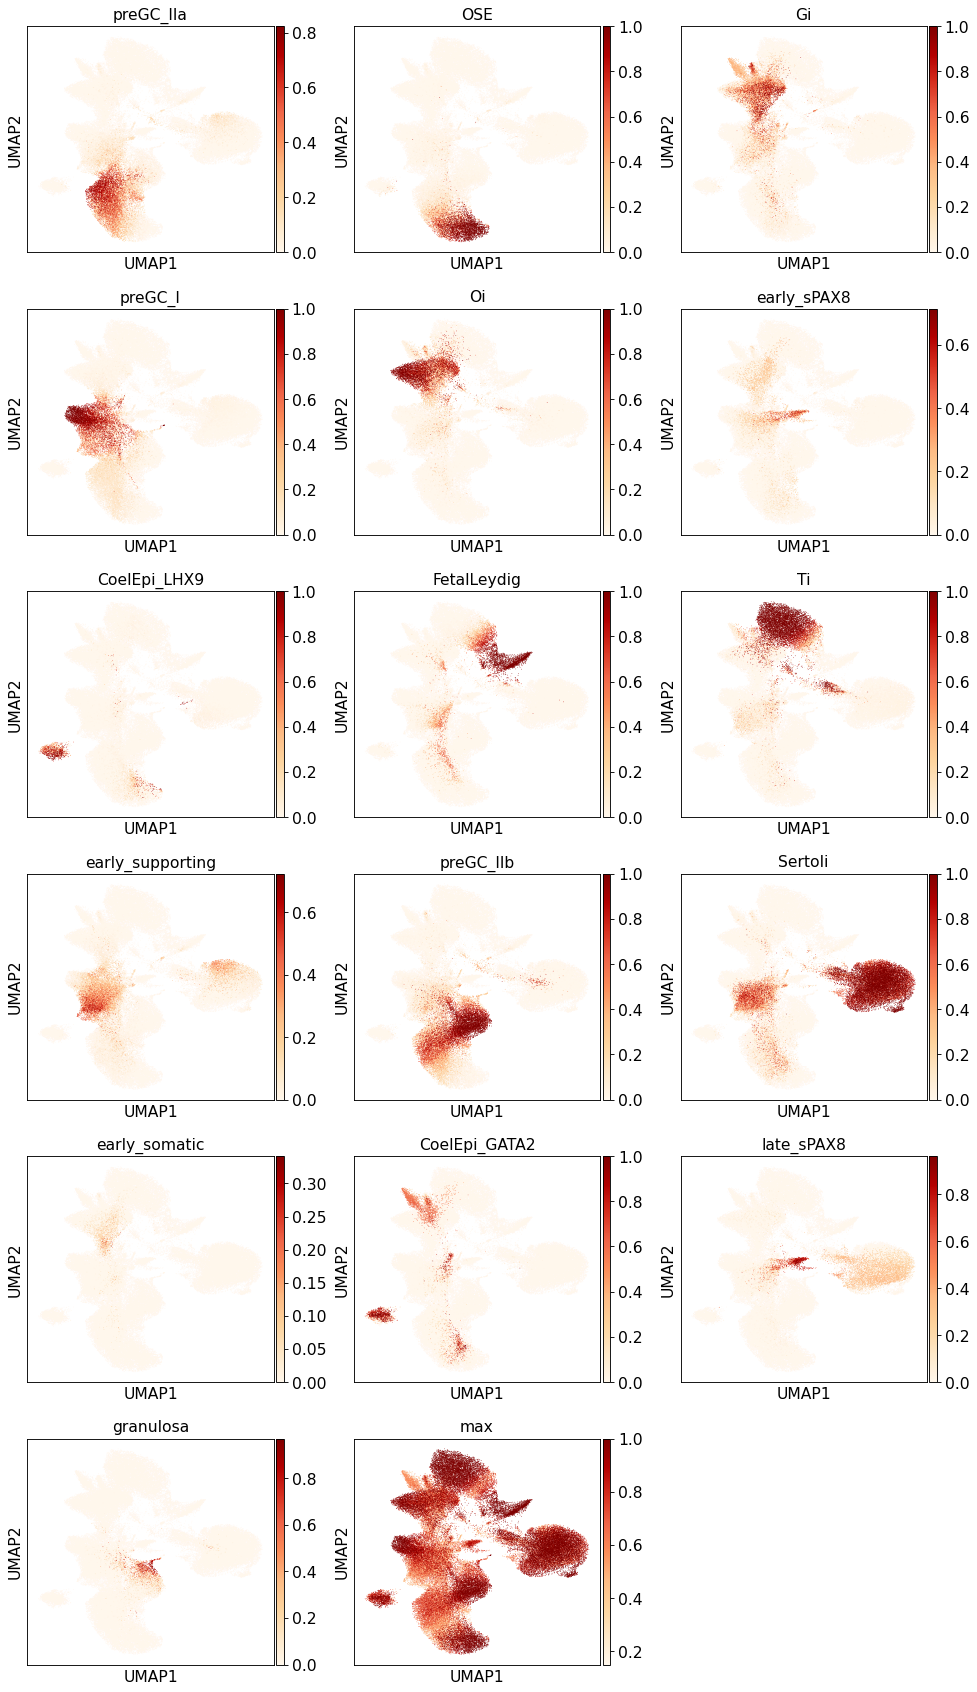

In [48]:
sc.pl.umap(adata, color = ['preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       'max'],
           ncols = 3, color_map = 'OrRd', save = "_probs_harmony.pdf")

#### Visualize position in the manifold of dual ATAC samples

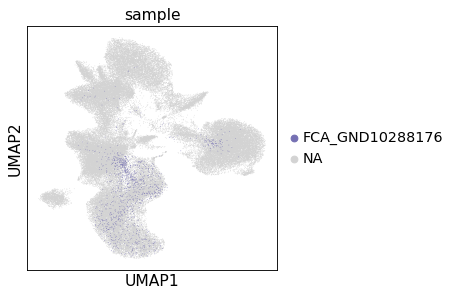

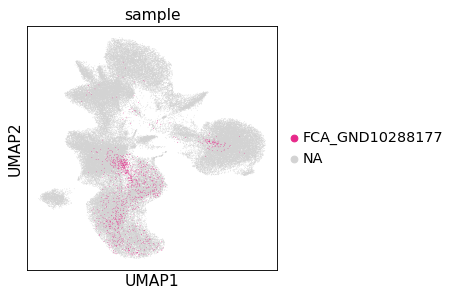

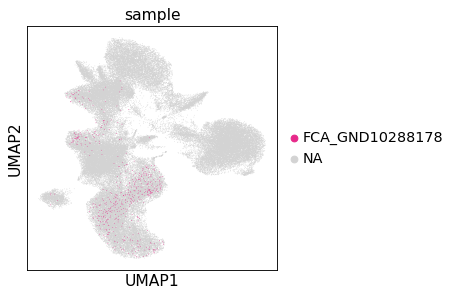

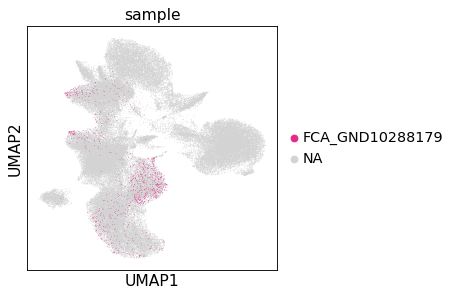

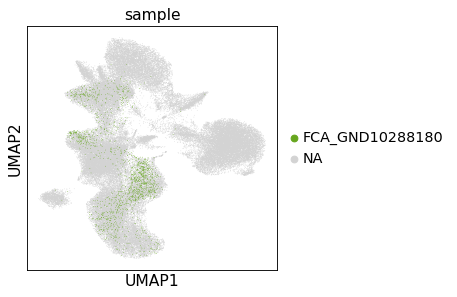

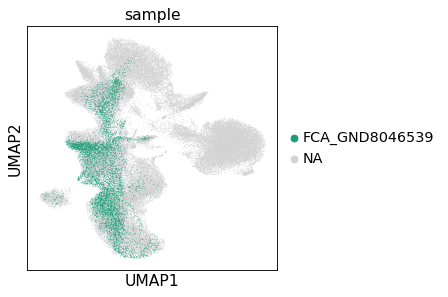

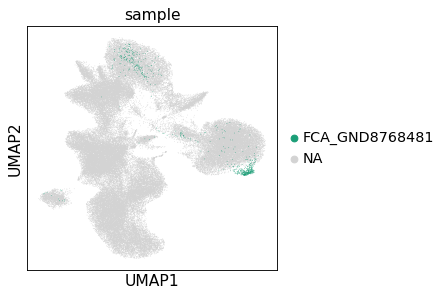

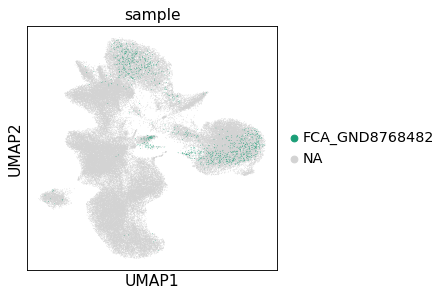

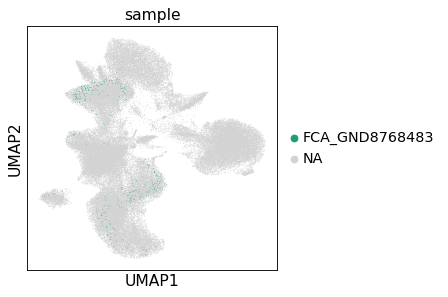

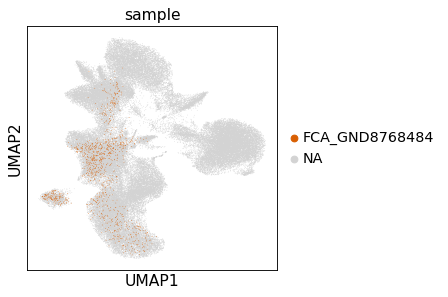

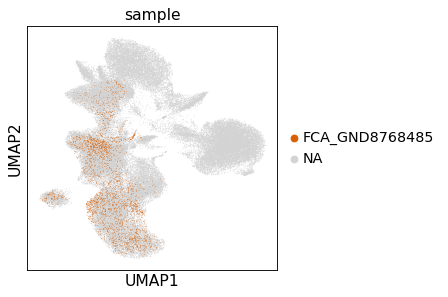

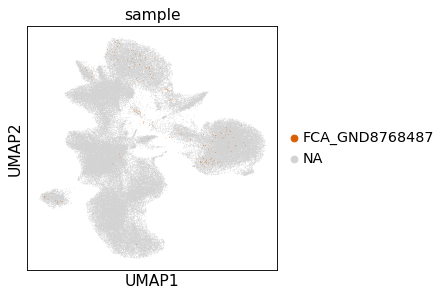

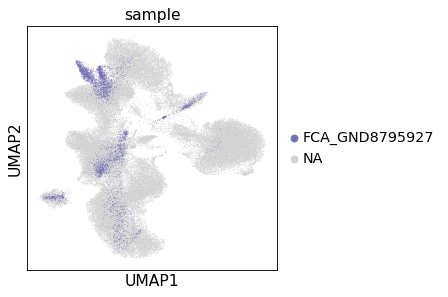

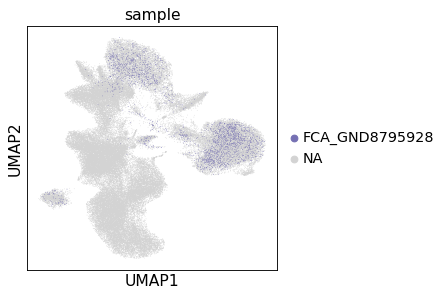

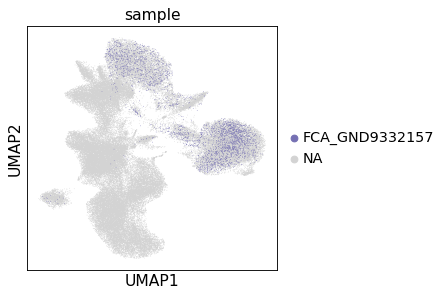

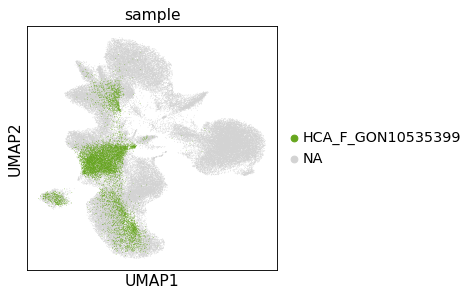

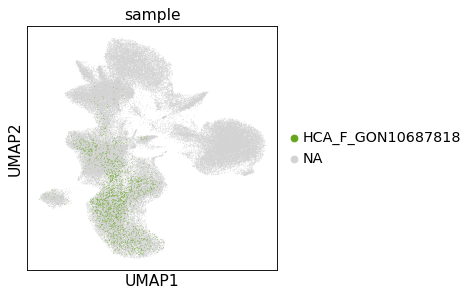

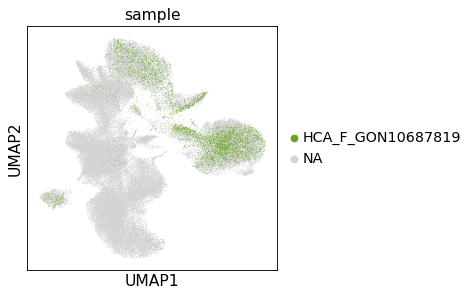

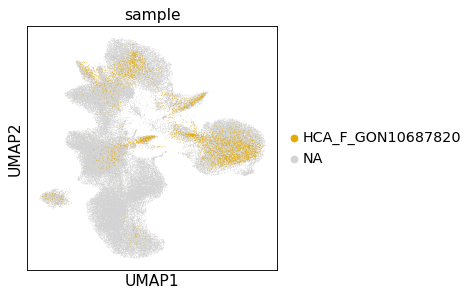

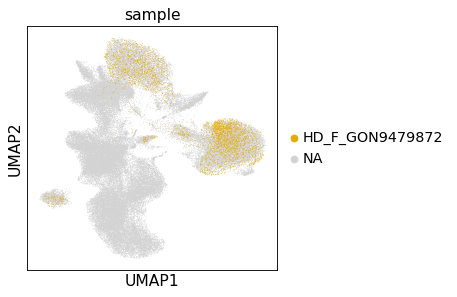

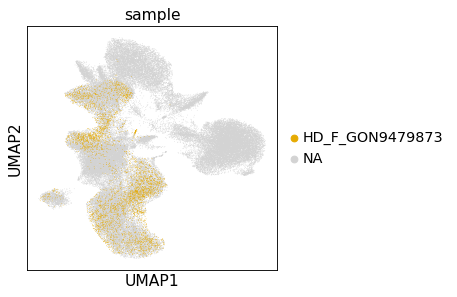

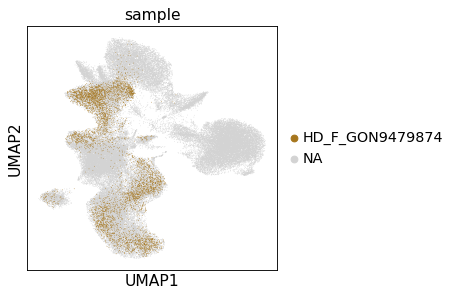

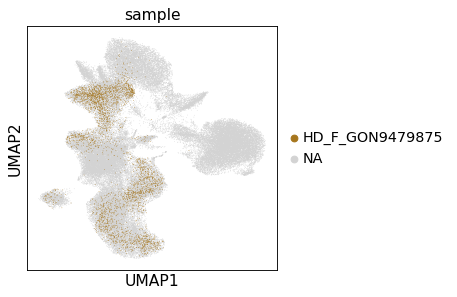

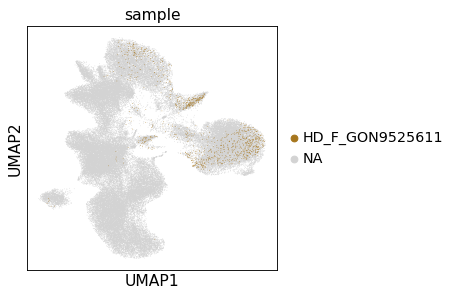

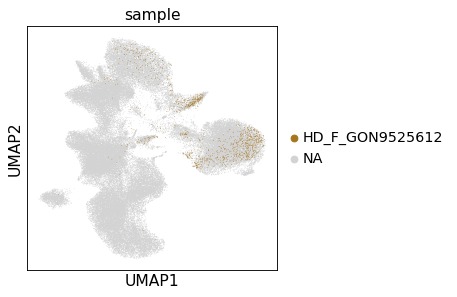

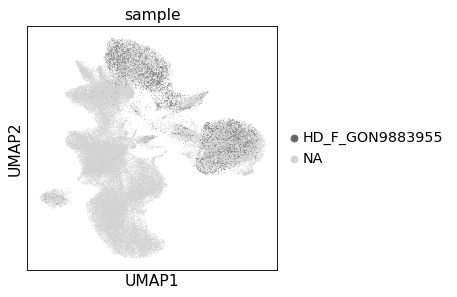

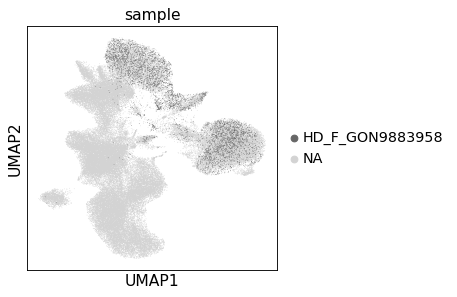

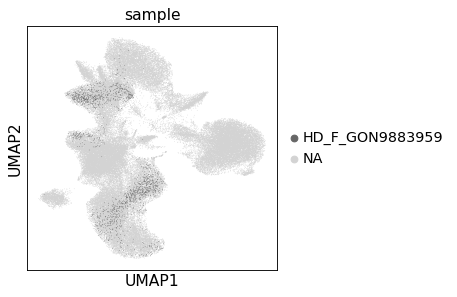

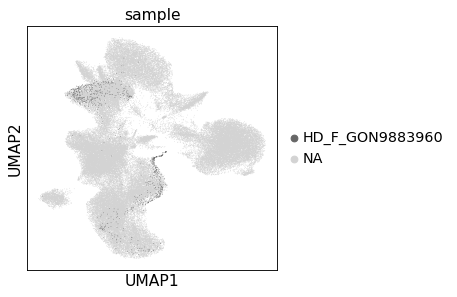

In [49]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

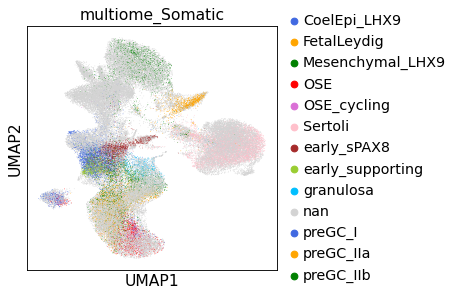

In [50]:
sc.pl.umap(adata, color = 'multiome_Somatic')

#### Clustering

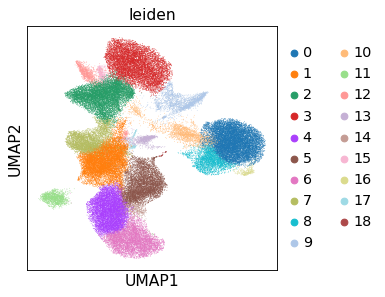

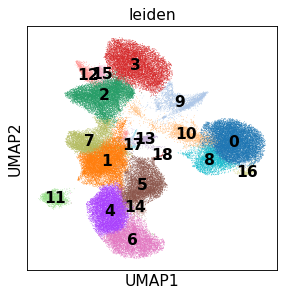

In [62]:
sc.tl.leiden(adata, resolution= 1, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf')

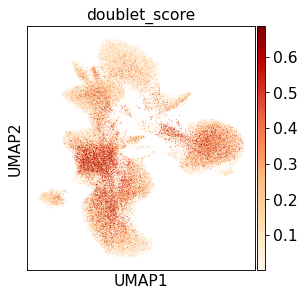

In [63]:
sc.pl.umap(adata, color = ['doublet_score'], color_map = 'OrRd')

In [64]:
adata

AnnData object with n_obs × n_vars = 76961 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8', 'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb', 'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_Somatic_colors', 'neighbors', 'sample_colors', 

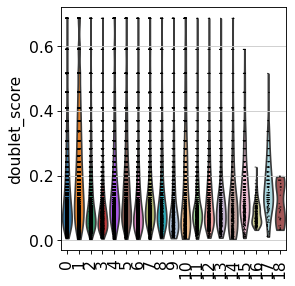

In [65]:
sc.pl.violin(adata, keys = ['doublet_score'], groupby = 'leiden', rotation = 90)

In [66]:
# Remove cluster 10 of low quality
adata = adata[[i not in ['10'] for i in adata.obs['leiden']]]
adata.shape

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(74592, 159132)

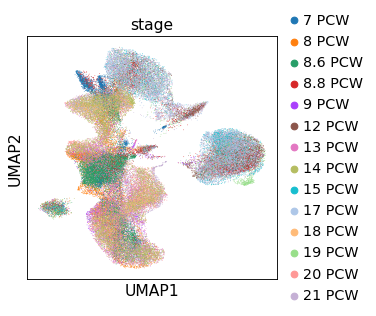

In [67]:
sc.pl.umap(adata, color = 'stage')

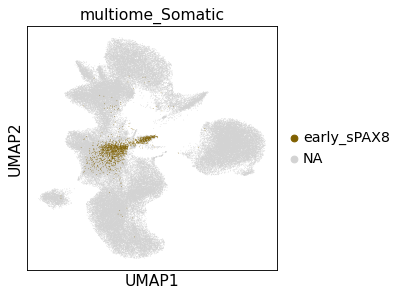

In [58]:
sc.pl.umap(adata, color = 'multiome_Somatic', groups = 'early_sPAX8')

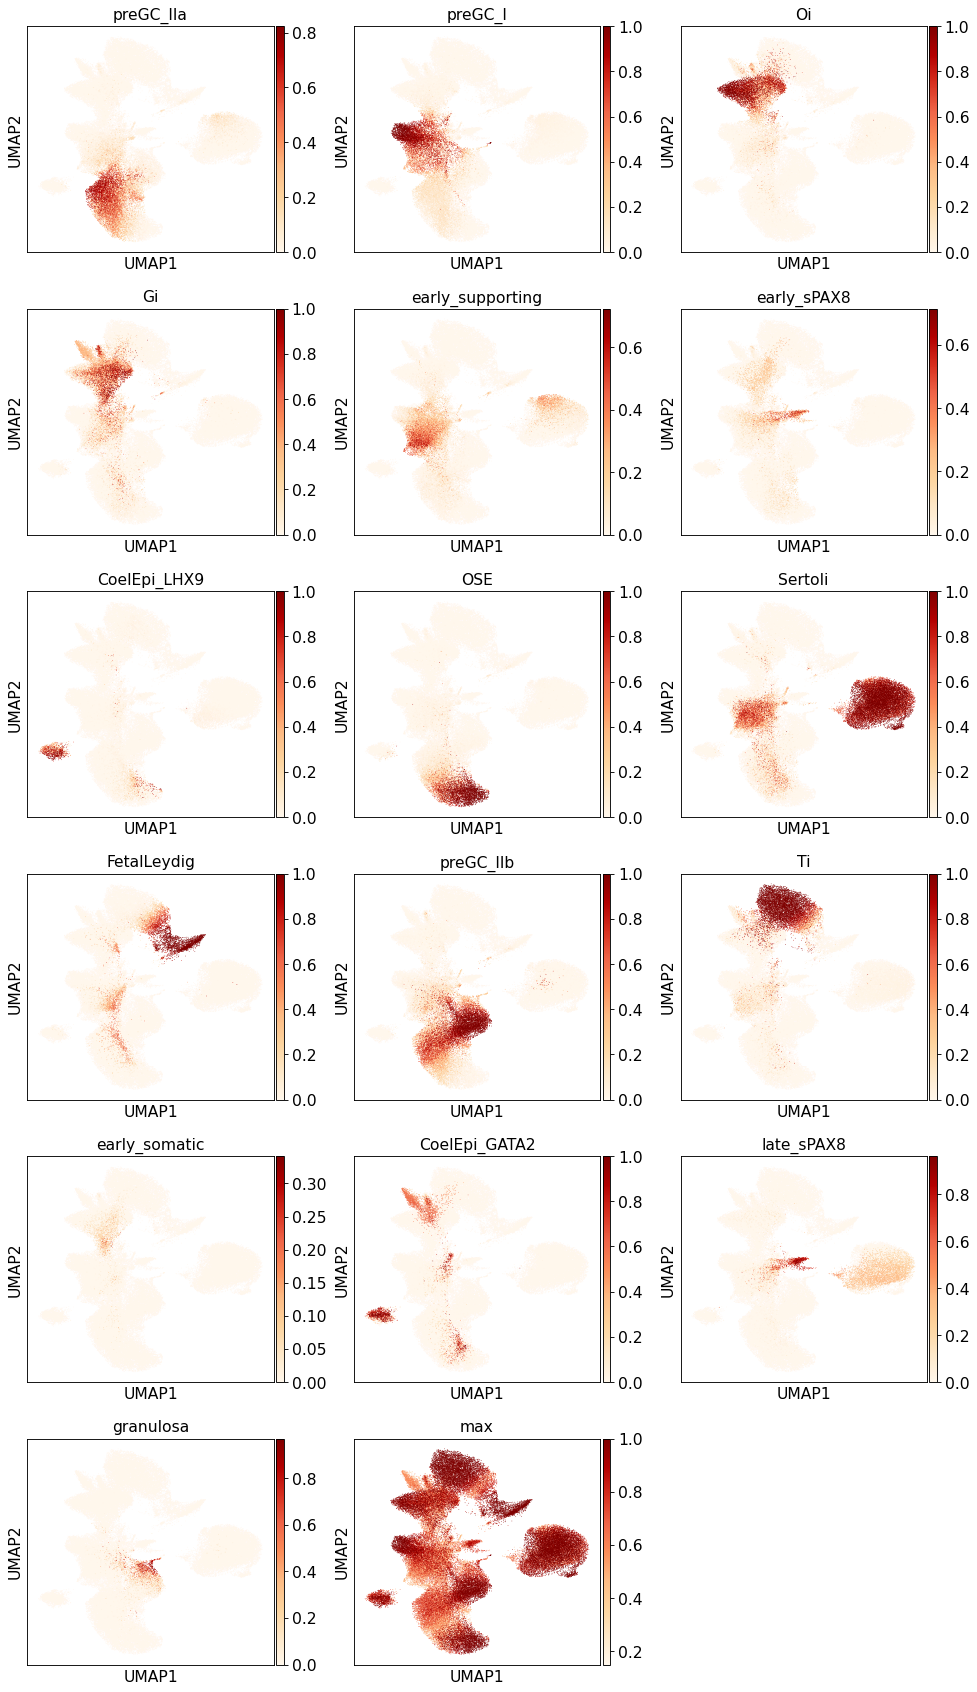

In [69]:
sc.pl.umap(adata, color = ['preGC_IIa', 'preGC_I', 'Oi', 'Gi', 'early_supporting', 'early_sPAX8', 'CoelEpi_LHX9', 'OSE', 'Sertoli',
                           'FetalLeydig', 'preGC_IIb', 'Ti', 'early_somatic', 'CoelEpi_GATA2', 
                           'late_sPAX8', 'granulosa', 'max'],
           ncols = 3, color_map = 'OrRd', save = "_probs_harmony.pdf")

... storing 'cell_type' as categorical


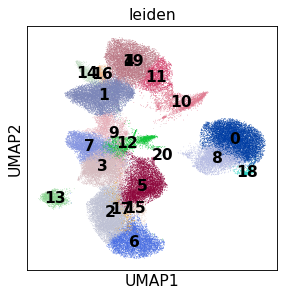

In [82]:
sc.tl.leiden(adata, resolution= 1.2, random_state = 1234)
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

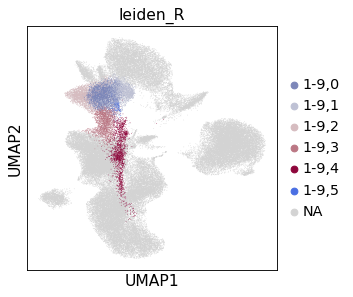

In [83]:
sc.tl.leiden(adata, resolution=0.4, random_state = 1234, restrict_to = ('leiden', ['1', '9']))
sc.pl.umap(adata, color='leiden_R', 
        groups = ['1-9,0', '1-9,1', '1-9,2', '1-9,3', '1-9,4', '1-9,5']
          )

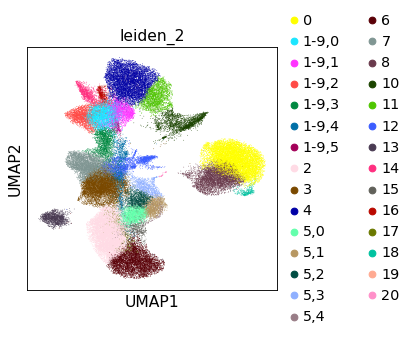

In [84]:
sc.tl.leiden(adata, resolution = 0.6,  random_state = 1234, restrict_to = ('leiden_R', ['5']),
            key_added = 'leiden_2')
sc.pl.umap(adata, color = 'leiden_2', 
          # groups = '2'
          )

In [33]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [9]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

#### Matrixplot of label transfer predictions vs leiden clusters

In [12]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample',
       'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75',
       'leiden', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       'max', 'leiden_R', 'leiden_2', 'leiden_3', 'stage_numeric',
       'cell_type'],
      dtype='object')

In [13]:
obs = adata.obs[[ 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       
       ]]

In [14]:
matrix = obs[[ 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
      
       ]].values
matrix.shape

(74592, 16)

In [19]:
plotting_obs = adata.obs[['leiden_2', 'cell_type']]
plotting_obs.shape

(74592, 2)

In [20]:
plotting_probs = [ 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa',
       ]
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(16)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(16, 1)

In [21]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 74592 × 16
    obs: 'leiden_2', 'cell_type'
    var: 'random_string'

In [22]:
ordered_probs = [ 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8',
       'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb',
       'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa', ]

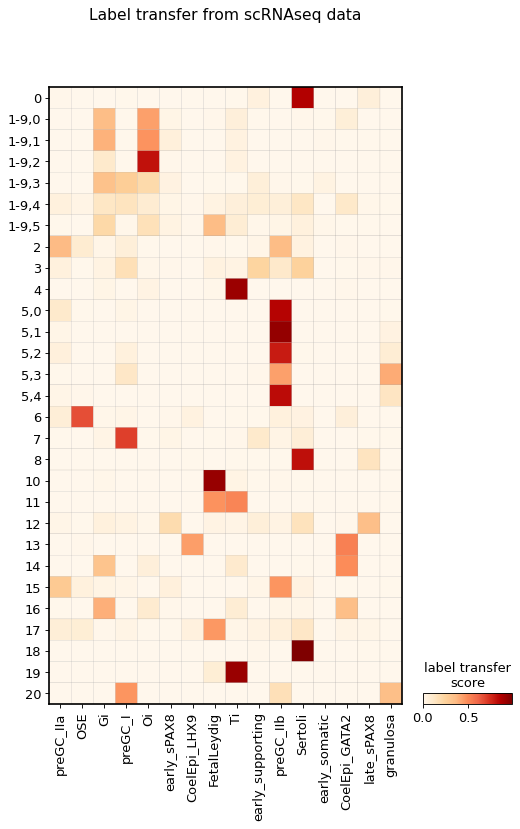

In [23]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden_2', cmap = 'OrRd',
                  save = '_leiden.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

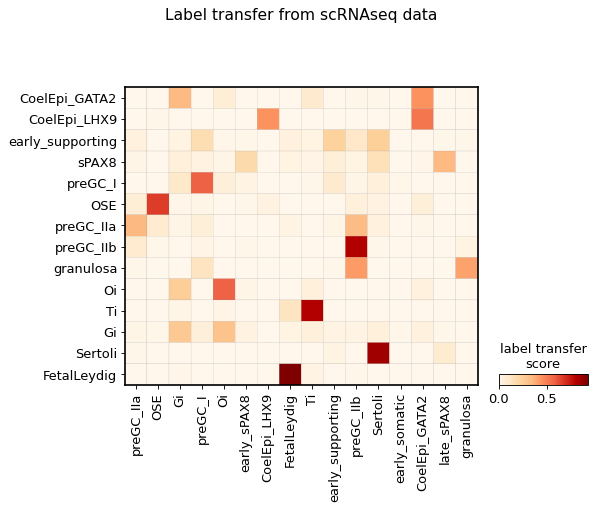

In [24]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

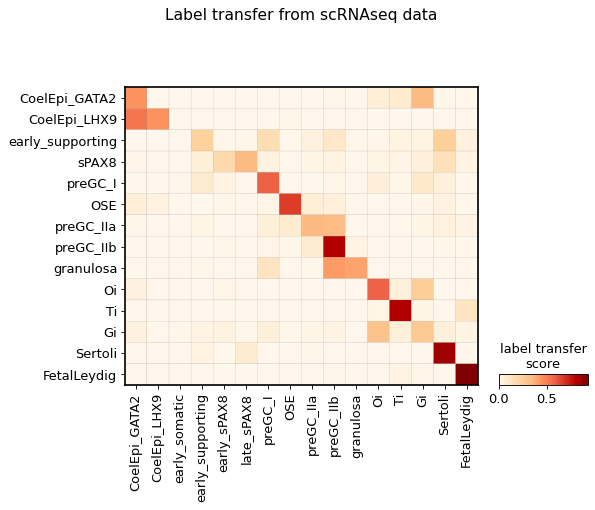

In [25]:
ordered_probs_present = ['CoelEpi_GATA2', 'CoelEpi_LHX9', 'early_somatic', 'early_supporting', 'early_sPAX8', 'late_sPAX8', 'preGC_I',
    'OSE','preGC_IIa', 'preGC_IIb', 'granulosa',
     'Oi', 'Ti', 'Gi', 'Sertoli', 'FetalLeydig']
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs_present, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot_present.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

In [13]:
adata.obs['multiome_Somatic'] = np.where(adata.obs['multiome_Somatic'] == 'OSE_cycling', 'OSE', adata.obs['multiome_Somatic'])

In [14]:
adata.obs['multiome_Somatic'].value_counts()

nan                 53541
Sertoli              4929
preGC_I              2826
preGC_IIa            2630
Mesenchymal_LHX9     2414
OSE                  1718
preGC_IIb            1592
early_sPAX8          1545
FetalLeydig          1026
early_supporting      999
granulosa             867
CoelEpi_LHX9          505
Name: multiome_Somatic, dtype: int64

In [15]:
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].astype('category')
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].cat.reorder_categories([
    'CoelEpi_LHX9', 'early_supporting', 'early_sPAX8', 'preGC_I', 'OSE', 'preGC_IIa', 
    'preGC_IIb', 'granulosa', 'Sertoli', 'FetalLeydig', 'Mesenchymal_LHX9', 'nan'
])

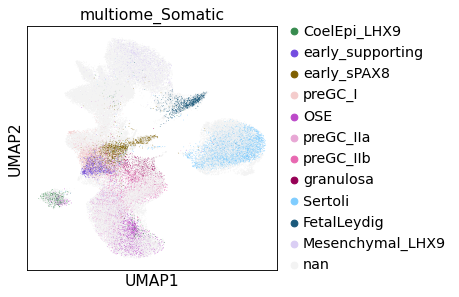

In [16]:
colors_somatic = {'CoelEpi_LHX9' : '#378b4e', 'Mesenchymal_LHX9' : '#dacef4', 'FetalLeydig' : '#1a597b', 'OSE' : '#bc49c9', 'OSE_cycling' : '#c565d0', 
                 'Sertoli' : '#7fcdff', 'early_sPAX8' : '#7f6000', 'early_supporting' : '#734ce0', 'granulosa' : '#960055', 
                 'preGC_I' : '#f4cccc', 'preGC_IIa' : '#e8a7d5', 'preGC_IIb' : '#e868b1', 'nan' : '#f3f3f3', 
                 'late_sPAX8' : '#a2997d', 'Oi' : '#ff7c73', 'Ti' : '#199de5', 'Gi' : '#e1dff0', 'sPAX8' : '#7f6000',
                 'CoelEpi_GATA2' : '#79bd5e'}
adata.uns['colors_somatic'] = colors_somatic
sc.pl.umap(adata, color = ['multiome_Somatic'], save = '_multiome_somatic', palette = colors_somatic)

In [44]:
adata.obs['stage'].value_counts()

14 PCW     9748
8 PCW      8890
8.6 PCW    8430
21 PCW     6596
13 PCW     6567
17 PCW     6037
12 PCW     4386
19 PCW     4294
7 PCW      4040
8.8 PCW    3946
9 PCW      3704
15 PCW     3677
20 PCW     2646
18 PCW     1631
Name: stage, dtype: int64

In [45]:
# Transform the stage variable in numeric to plot the PCW as a gradient
pcws_dict = {'11 PCW' : 11, '12 PCW' : 12, '13 PCW' : 13, '14 PCW' : 14, '15 PCW' : 15, '17 PCW' : 17,
       '18 PCW' : 18, '19 PCW' : 19, '21 PCW' : 21, '7 PCW' : 7, '8 PCW' : 8, '9 PCW' : 9, 
            '20 PCW' : 20}
adata.obs['stage_numeric'] = adata.obs['stage'].map(pcws_dict)
adata.obs['stage_numeric'].value_counts(dropna = False)
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

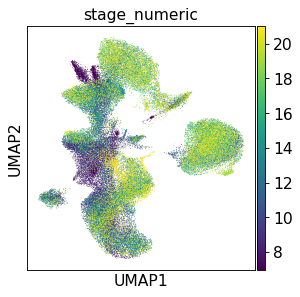

In [46]:
sc.pl.umap(adata, color='stage_numeric',legend_fontsize = 'medium', 
           legend_fontweight = 'medium', color_map = 'viridis',
           save='_stage.pdf')

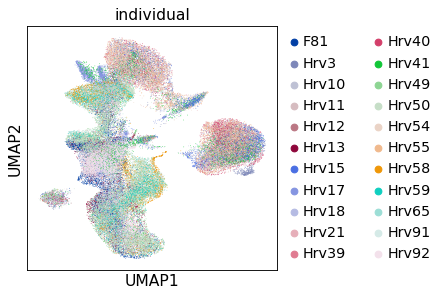

In [47]:
sc.pl.umap(adata, color = 'individual', save = '_individual')

#### Annotate cells based on label transfer + dual RNA annotations

In [49]:
adata

AnnData object with n_obs × n_vars = 74592 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_IIa', 'OSE', 'Gi', 'preGC_I', 'Oi', 'early_sPAX8', 'CoelEpi_LHX9', 'FetalLeydig', 'Ti', 'early_supporting', 'preGC_IIb', 'Sertoli', 'early_somatic', 'CoelEpi_GATA2', 'late_sPAX8', 'granulosa', 'max', 'leiden_R', 'leiden_2', 'leiden_3', 'stage_numeric'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'mul

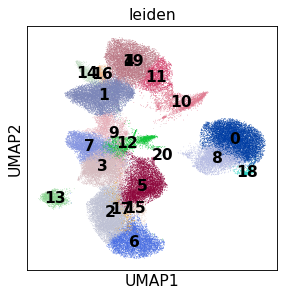

In [97]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data' 
         # groups = ['5,0', '5,1', '5,2', '5,3', '5,4', '5,5', '5,6', '5,7', '5,8']
          )

In [99]:
cell_type = {'0' : 'Sertoli', '18' : 'Sertoli', '8' : 'Sertoli', '10' : 'FetalLeydig', '19' : 'Ti', '11' : 'Ti', '4' : 'Ti',
             '14' : 'CoelEpi_GATA2', '16' : 'CoelEpi_GATA2', '13' : 'CoelEpi_LHX9', '17' : 'preGC_IIa', '15' : 'preGC_IIb',
               '3' : 'early_supporting', '7' : 'preGC_I', '15' : 'preGC_IIb', '2' : 'preGC_IIa', 
             '6' : 'OSE', '19' : 'Ti', '1-9,0' : 'Oi', '1-9,1' : 'Gi', '1-9,2' : 'Oi', '1-9,3' : 'preGC_I', 
             '1-9,4' : 'Gi', '1-9,5' : 'Gi', '5,0' : 'preGC_IIb', '5,1' : 'preGC_IIb', '5,2' : 'preGC_IIb', 
             '5,3' : 'granulosa', '20' : 'granulosa', '5,4' : 'preGC_IIb',
             '12' : 'sPAX8',  
            }
adata.obs['cell_type'] = adata.obs['leiden_2'].map(cell_type)
adata.obs['cell_type'].value_counts(dropna = False)

Sertoli             14285
Ti                   8828
preGC_IIa            8676
preGC_I              6677
early_supporting     6506
preGC_IIb            5733
Oi                   5657
OSE                  5007
Gi                   4237
FetalLeydig          2328
sPAX8                2201
CoelEpi_GATA2        1711
CoelEpi_LHX9         1569
granulosa            1177
Name: cell_type, dtype: int64

In [17]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
   'CoelEpi_GATA2', 'CoelEpi_LHX9', 'early_supporting', 'sPAX8', 'preGC_I',
    'OSE','preGC_IIa', 'preGC_IIb', 'granulosa',
     'Oi', 'Ti', 'Gi', 'Sertoli', 'FetalLeydig'
])

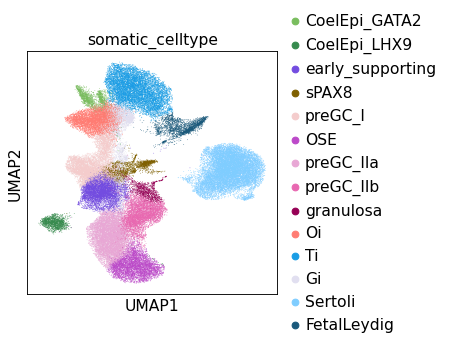

In [18]:
sc.pl.umap(adata, color = 'cell_type', palette = adata.uns['colors_somatic'], 
           legend_fontsize = "medium", legend_fontweight = "medium", frameon = True, 
           title = "somatic_celltype",
           save = "_annotations.pdf", )

In [12]:
adata.shape

(74592, 159132)

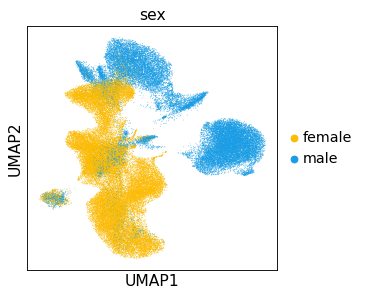

In [11]:
sc.pl.umap(adata, color = 'sex', palette = [ '#fbbc04','#199de5',], save = '_sex')

In [107]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

In [10]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

#### Save somatic annotations 

In [108]:
adata.obs.to_csv(outdir + experiment_prefix + 'annotations.csv')

#### End of notebook